### Data Loading

In [ ]:
# Load the uploaded files to check their contents and understand the structure of the dataset and the notebook.
import pandas as pd
from google.colab import drive

# from google.colab import drive
drive.mount('/content/drive')

# Load the dataset file to inspect its structure
crashes_df = pd.read_csv("/content/drive/Shareddrives/CMPE-257/data/crashes.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Cleaning

Clean the dataset tfrom values that skew or pollute the data

In [ ]:
# Remove entries where Longitude or Latitude is 0
crashes_df = crashes_df[(crashes_df['Longitude'] != 0) & (crashes_df['Latitude'] != 0)]

# Display basic information and the first few rows of the dataset
crashes_df.info(), crashes_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 11251 entries, 0 to 11251
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _id                        11251 non-null  int64  
 1   CrashFactId                11251 non-null  int64  
 2   Name                       11251 non-null  object 
 3   MinorInjuries              11251 non-null  int64  
 4   ModerateInjuries           11251 non-null  int64  
 5   SevereInjuries             11251 non-null  int64  
 6   FatalInjuries              11251 non-null  int64  
 7   TcrNumber                  11251 non-null  object 
 8   CityDamageFlag             11251 non-null  bool   
 9   ShortFormFlag              11251 non-null  bool   
 10  Distance                   10653 non-null  float64
 11  CrashDateTime              11251 non-null  object 
 12  PedestrianAction           11251 non-null  object 
 13  RoadwaySurface             11251 non-null  object 


(None,
    _id  CrashFactId           Name  MinorInjuries  ModerateInjuries  \
 0    1       711791  CR-0000100908              2                 0   
 1    2       692417  CR-0000097700              1                 0   
 2    3       682960  CR-0000092543              0                 0   
 3    4       682508  CR-0000092075              1                 0   
 4    5       683141  CR-0000092724              0                 0   
 
    SevereInjuries  FatalInjuries    TcrNumber  CityDamageFlag  ShortFormFlag  \
 0               0              0  23-306-0529           False          False   
 1               0              0  23-081-0828           False          False   
 2               0              0  22-162-0927           False          False   
 3               0              0  22-093-0636           False          False   
 4               0              0  22-045-4004           False           True   
 
    ...  PedestrianDirectionTo DirectionFromIntersection Comment Speedi

### Feature Engineering

Weather
Clear      8393
Unknown    1763
Rain        561
Cloudy      487
Other        25
Fog          12
Wind          9
Snow          1
Name: count, dtype: int64
Weather
Clear      74.597814
Unknown    15.669718
Rain        4.986223
Cloudy      4.328504
Other       0.222202
Fog         0.106657
Wind        0.079993
Snow        0.008888
Name: count, dtype: float64


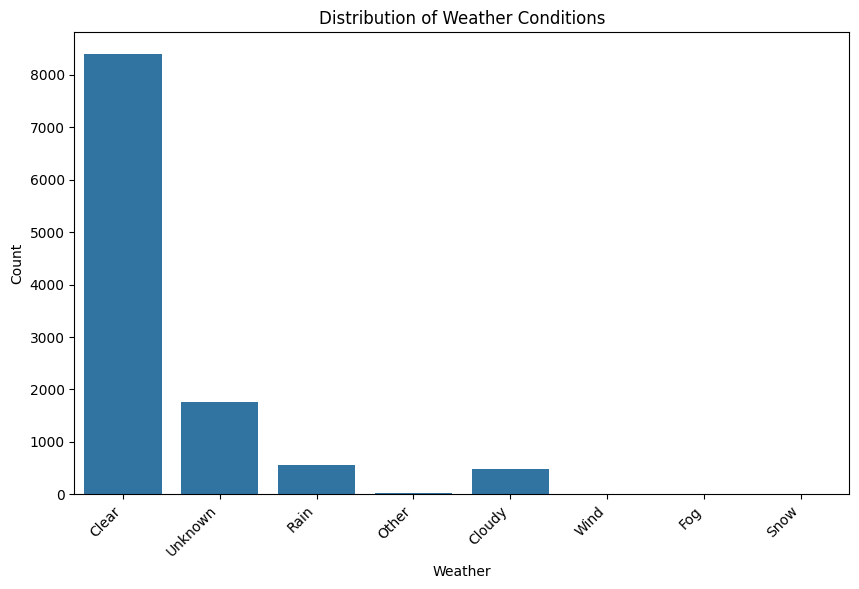

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check the imbalance of the 'Weather' column
weather_counts = crashes_df['Weather'].value_counts()
print(weather_counts)

# Calculate and print the percentage of each weather type
weather_percentages = weather_counts / len(crashes_df) * 100
print(weather_percentages)

# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=crashes_df, x='Weather')
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Consolidate the columns to remove the imbalance and simplify it for the model.

In [ ]:
# Simplify the weather column to binary. 'Clear' or 'Rain' due to imbalance of the dataset
crashes_df['Weather'] = crashes_df['Weather'].apply(lambda x: x if x in ['Clear', 'Rain'] else 'Other')


In [ ]:
crashes_df['InjuryType'] = ((crashes_df['ModerateInjuries'] > 0) |
                    (crashes_df['SevereInjuries'] > 0) |
                    (crashes_df['FatalInjuries'] > 0)).astype(int)

#### Analyzing injury and accident correlation

Correlation between accident count and severe injuries: 0.4477


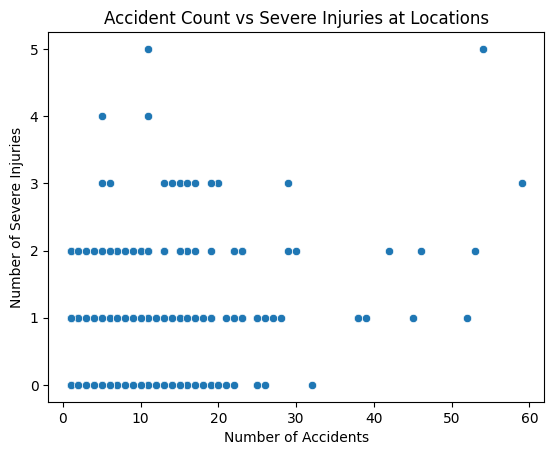

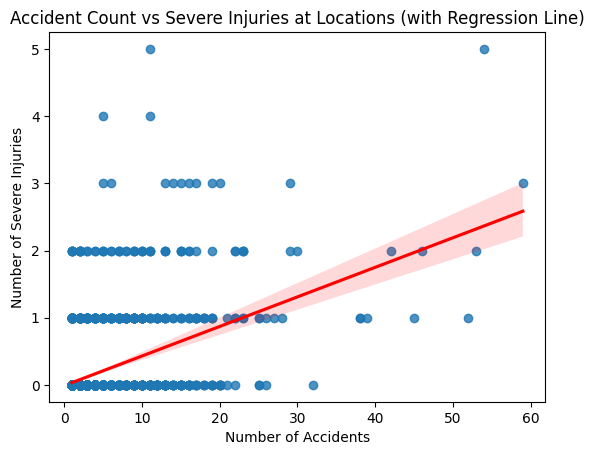

In [ ]:

# Aggregate Data by Location (Latitude, Longitude, IntersectionNumber)
grouped_df = crashes_df.groupby(['Latitude', 'Longitude', 'IntersectionNumber']).agg(
    accident_count=('InjuryType', 'size'),    # Number of accidents at each location
    severe_injuries=('SevereInjuries', 'sum') # Sum of severe injuries
).reset_index()

# Calculate Correlation Between Accident Count and Severe Injuries
correlation = grouped_df['accident_count'].corr(grouped_df['severe_injuries'])
print(f"Correlation between accident count and severe injuries: {correlation:.4f}")

# Visualize the Relationship
sns.scatterplot(data=grouped_df, x='accident_count', y='severe_injuries')
plt.title('Accident Count vs Severe Injuries at Locations')
plt.xlabel('Number of Accidents')
plt.ylabel('Number of Severe Injuries')
plt.show()

# Optional: Add a regression line to visualize trend
sns.regplot(data=grouped_df, x='accident_count', y='severe_injuries', line_kws={"color":"red"})
plt.title('Accident Count vs Severe Injuries at Locations (with Regression Line)')
plt.xlabel('Number of Accidents')
plt.ylabel('Number of Severe Injuries')
plt.show()


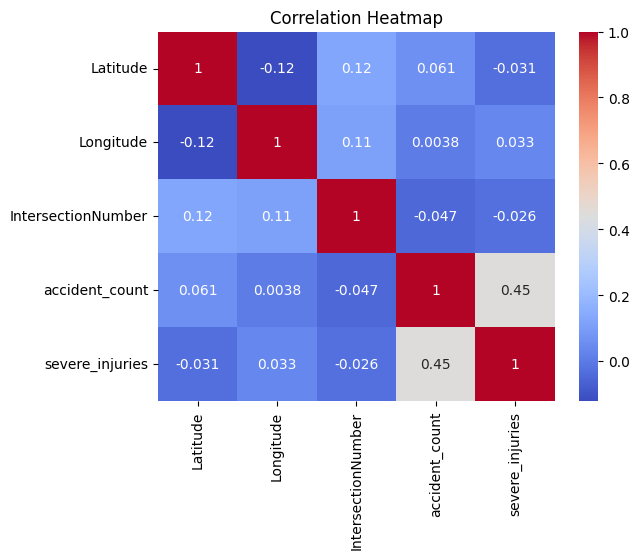

In [ ]:
# Heatmap of correlation between features
sns.heatmap(grouped_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Define the Classifier and label the data

Since accident count and severe injuries correlate positively, we decided to focus on accident count as a criteria for the classfier  

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Round latitude and longitude to group nearby accidents
crashes_df['RoundedLatitude'] = crashes_df['Latitude'].round(3)
crashes_df['RoundedLongitude'] = crashes_df['Longitude'].round(3)

# Calculate the frequency of accidents and injury occurrences per location
location_risk = crashes_df.groupby(['RoundedLatitude', 'RoundedLongitude']).agg(
    accident_count=('InjuryType', 'size'),       # Total accidents in this location
    injury_count=('InjuryType', 'sum')           # Sum of injury occurrences in this location
).reset_index()

location_risk.head()

# Define thresholds for high-risk criteria (tune these as needed)
accident_threshold = 5 # Example threshold for the number of accidents

# Assign HighRisk based on the thresholds
location_risk['LocationRisk'] = ((location_risk['accident_count'] >= accident_threshold)).astype(int)

# Merge HighRisk back into the original dataframe
# Merge on RoundedLatitude and RoundedLongitude to assign HighRisk to each accident instance
crashes_df = crashes_df.merge(location_risk[['RoundedLatitude', 'RoundedLongitude', 'LocationRisk']],
                                on=['RoundedLatitude', 'RoundedLongitude'],
                                how='left')

# Drop the temporary columns used for grouping
crashes_df = crashes_df.drop(columns=['RoundedLatitude', 'RoundedLongitude'])

We identify high-risk traffic accident locations by grouping nearby accidents based on their geographic coordinates. By rounding the latitude and longitude values to three decimal places, accidents within approximately 100 meters of each other are aggregated. This simplifies the data and highlights accident-prone areas while avoiding excessive granularity.

After grouping, the we calculate the total number of accidents (accident_count) and injuries (injury_count) at each location. A threshold is then applied to classify locations as high-risk (LocationRisk) if they exceed a specified accident count, making it possible to identify and analyze dangerous zones. Finally, the high-risk classification is merged back into the original dataset to assign a risk label to each individual accident instance for further modeling or analysis. This process helps focus on spatial patterns of risk and simplifies data-driven decision-making.

#### Analyze Target Class Imbalance

LocationRisk
1    6295
0    4956
Name: count, dtype: int64


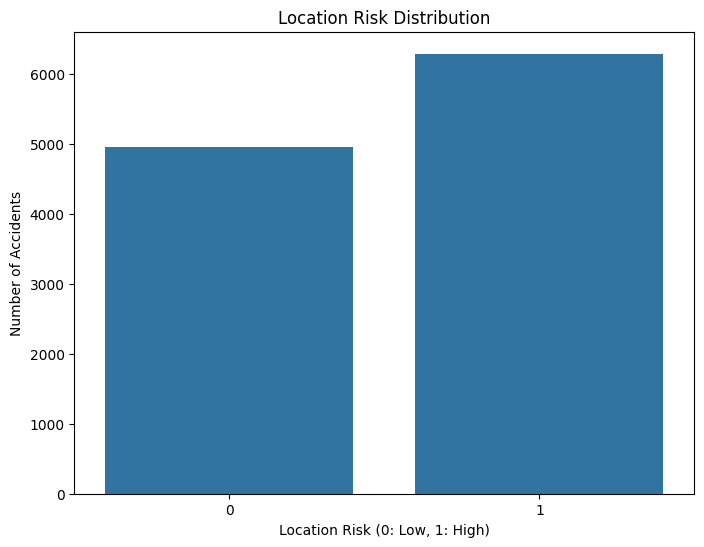

In [ ]:
# see data imbalance for LocationRisk

# Calculate the value counts for 'LocationRisk'
location_risk_counts = crashes_df['LocationRisk'].value_counts()

# Print the value counts
print(location_risk_counts)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='LocationRisk', data=crashes_df)
plt.title('Location Risk Distribution')
plt.xlabel('Location Risk (0: Low, 1: High)')
plt.ylabel('Number of Accidents')
plt.show()

We analyzed and visualized the class distribution of the LocationRisk variable to assess data imbalance. By calculating the value counts, we observed the number of accidents classified as low-risk (0) and high-risk (1). The bar plot further highlights this distribution, showing a slightly higher number of high-risk locations compared to low-risk ones in the dataset.

This analysis is important because imbalanced data can affect the performance of machine learning models, potentially biasing them toward the majority class. Identifying this imbalance helps us decide on appropriate strategies, such as oversampling, undersampling, or using class-weight adjustments, to ensure the model performs effectively for both classes.


#### Feature Extraction & Selection  

We wanted to extract the time of day, hour and day of week features from the CrashDateTime to help with training our model.

In [ ]:
# Feature selection
selected_features = ['Latitude', 'Longitude', 'CrashDateTime', 'Weather', 'Lighting', 'SpeedingFlag', 'InjuryType', 'IntersectionNumber']
data = crashes_df[selected_features + ['LocationRisk']].copy()

# Extract time-based features from CrashDateTime
data['CrashDateTime'] = pd.to_datetime(crashes_df['CrashDateTime'], errors='coerce')
data['Hour'] = data['CrashDateTime'].dt.hour
data['DayOfWeek'] = data['CrashDateTime'].dt.dayofweek
data['Month'] = data['CrashDateTime'].dt.month
data['isWeekday'] = data['DayOfWeek'].apply(lambda x: 1 if x < 5 else 0)

# Define "time of day" categories
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

data['TimeOfDay'] = data['Hour'].apply(get_time_of_day)

# Drop original CrashDateTime column
data = data.drop(columns=['CrashDateTime'])

<ipython-input-10-808172afd2ca>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['CrashDateTime'] = pd.to_datetime(crashes_df['CrashDateTime'], errors='coerce')


In [ ]:
data.head()

,Latitude,Longitude,Weather,Lighting,SpeedingFlag,InjuryType,IntersectionNumber,LocationRisk,Hour,DayOfWeek,Month,isWeekday,TimeOfDay
0,37.300611,-121.936797,Clear,Daylight,True,0,110241,0,14,3,11,1,Afternoon
1,37.302711,-121.966043,Clear,Dark - Street Light,True,0,22770,0,22,2,3,1,Evening
2,37.306535,-121.966047,Clear,Daylight,False,0,22857,0,22,5,6,0,Evening
3,37.305191,-121.966039,Clear,Daylight,False,0,22868,1,17,6,4,0,Afternoon
4,37.305191,-121.966039,Other,Daylight,False,0,22868,1,8,0,2,1,Morning


### Feature Encoding

In [ ]:
# Convert 'SpeedingFlag' from True/False to 1/0
crashes_df['SpeedingFlag'] = crashes_df['SpeedingFlag'].astype(int)

# Verify the change
print(crashes_df['SpeedingFlag'].head())

0    1
1    1
2    0
3    0
4    0
Name: SpeedingFlag, dtype: int64


In [ ]:
# Handle missing values
data = data.dropna()  # Dropping rows with NA for simplicity
# Encode categorical variables
label_encoders = {}
for col in ['Weather', 'Lighting', 'TimeOfDay']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

### K-means Clustering

#### K-means Clustering metrics evaluation

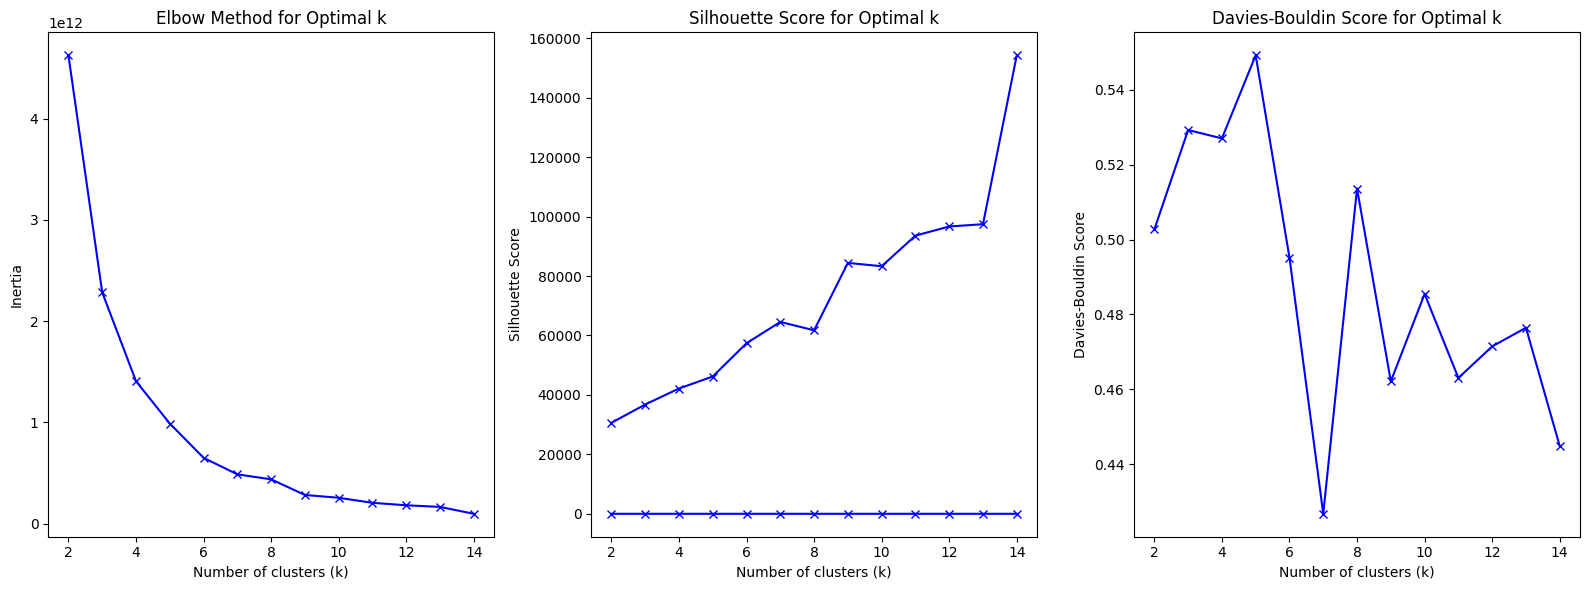

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# List to hold metrics for each k
inertia = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Define range for k
K = range(2, 15)  # Starting from 2 since silhouette score doesn't work with k=1

# Calculate metrics for each k
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)  # Fit model and get labels in one step

    # Append inertia (used in the elbow method)
    inertia.append(kmeans.inertia_)

    # Append silhouette score
    silhouette_scores.append(silhouette_score(data, labels))

    # Append Calinski-Harabasz score
    calinski_harabasz_scores.append(calinski_harabasz_score(data, labels))

    # Append Davies-Bouldin score
    davies_bouldin_scores.append(davies_bouldin_score(data, labels))

# Plot the metrics
plt.figure(figsize=(16, 6))

# Elbow Method Inertia Plot
plt.subplot(1, 3, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Silhouette Score Plot
plt.subplot(1, 3, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

# Silhouette Score Plot
plt.subplot(1, 3, 2)
plt.plot(K, calinski_harabasz_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

# Davies-Bouldin Score Plot
plt.subplot(1, 3, 3)
plt.plot(K, davies_bouldin_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score for Optimal k')

plt.tight_layout()
plt.show()

From here we find the optimal k value seems to be between 7, 8 and 9.

#### Clustering

In [ ]:
# Drop the target variable ('LocationRisk') from the data
data_without_target = data.drop(columns=['LocationRisk'])

# Select relevant numerical features
numerical_features = ['Latitude', 'Longitude', 'Month']

# Standardize the numerical features
scaler = StandardScaler()
data_scaled = data_without_target.copy()
data_scaled[numerical_features] = scaler.fit_transform(data_scaled[numerical_features])

# Apply KMeans clustering
k_optimal = 9
kmeans = KMeans(n_clusters=k_optimal, random_state=42)

# Fit the KMeans model and get cluster labels
data_without_target['Cluster'] = kmeans.fit_predict(data_scaled)

# Add the Cluster column back to the original data (with LocationRisk column)
data['Cluster'] = data_without_target['Cluster']

# Display a sample of the data with cluster assignments
data[['Latitude', 'Longitude', 'Cluster']].head()


,Latitude,Longitude,Cluster
0,37.300611,-121.936797,2
1,37.302711,-121.966043,1
2,37.306535,-121.966047,1
3,37.305191,-121.966039,1
4,37.305191,-121.966039,1


## Supervised Learning

### Split the dataset

In [ ]:
# Split the data
X = data.drop(columns=['LocationRisk', 'isWeekday', 'Weather', 'InjuryType', 'DayOfWeek', 'Hour'])
y = data['LocationRisk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X.columns

Index(['Latitude', 'Longitude', 'Lighting', 'SpeedingFlag',
       'IntersectionNumber', 'Month', 'TimeOfDay', 'Cluster'],
      dtype='object')

In [ ]:
data.columns

Index(['Latitude', 'Longitude', 'Weather', 'Lighting', 'SpeedingFlag',
       'InjuryType', 'IntersectionNumber', 'LocationRisk', 'Hour', 'DayOfWeek',
       'Month', 'isWeekday', 'TimeOfDay', 'Cluster'],
      dtype='object')

### Trees

#### Random Forest & Feature Importance

In [ ]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Latitude', 'Longitude']
X_train[numerical_features] = scaler.fit_transform(
    X_train[numerical_features]
)
X_test[numerical_features] = scaler.transform(
    X_test[numerical_features]
)

# Train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score', f1)
print(conf_matrix)

from sklearn.model_selection import StratifiedKFold, cross_validate

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the metrics to evaluate
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation
cv_results = cross_validate(
    rf_model, X, y, cv=cv, scoring=scoring, return_train_score=True
)

# Calculate mean and standard deviation for each metric
for metric in scoring:
    print("Stratified K-Fold Cross Validation:")
    print(f"{metric.capitalize()}: {cv_results[f'test_{metric}'].mean():.3f} ± {cv_results[f'test_{metric}'].std():.3f}")

Accuracy: 0.8622834295868503
Precision: 0.8396564065855404
Recall: 0.931691818903892
F1-Score 0.8832831325301205
[[ 768  224]
 [  86 1173]]
Stratified K-Fold Cross Validation:
Accuracy: 0.861 ± 0.013
Stratified K-Fold Cross Validation:
Precision: 0.845 ± 0.014
Stratified K-Fold Cross Validation:
Recall: 0.922 ± 0.009
Stratified K-Fold Cross Validation:
F1: 0.882 ± 0.011


##### ROC Curve

Accuracy: 0.8622834295868503
Precision: 0.8396564065855404
Recall: 0.931691818903892
F1-Score 0.8832831325301205
ROC AUC: 0.9417332304184067
[[ 768  224]
 [  86 1173]]


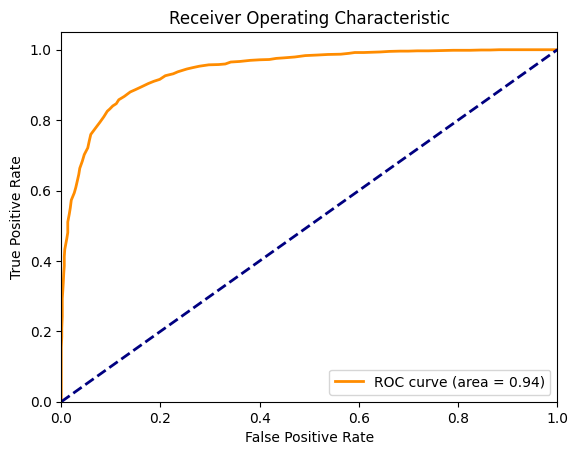

In [ ]:
# prompt: give me an ROC metric and AOC

from sklearn.metrics import roc_curve, auc

# Evaluate the model (add ROC and AUC)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc) # Print the ROC AUC score
print(confusion_matrix(y_test, y_pred))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Some key takeaways:
* The model demonstrates a strong overall performance in prediciting the classifier
* After experiementation we found that n_estimators=100 was the most optimal parameter to set.
* Acheived a decent acccuracy of 86.23% with a high recall value which indicates it is identifying most high risk locations. However the precision is slightly lower indicating that some low risk locations
* The F1-score of 88.3% reflects a solid balance between precision and recall
* ROC AUC of 0.944 shows that the model is discrimating well between the classes.
* Cross vlaidation results confirm the model's stability, low variance and
* Given the feature importances we could experiemnt with removing some features with lower importance to see if accuracy and precision would improve.

##### Feature Importance

              feature  importance
4  IntersectionNumber    0.267974
0            Latitude    0.266666
1           Longitude    0.250434
5               Month    0.082678
7             Cluster    0.051779
2            Lighting    0.033433
6           TimeOfDay    0.033094
3        SpeedingFlag    0.013942


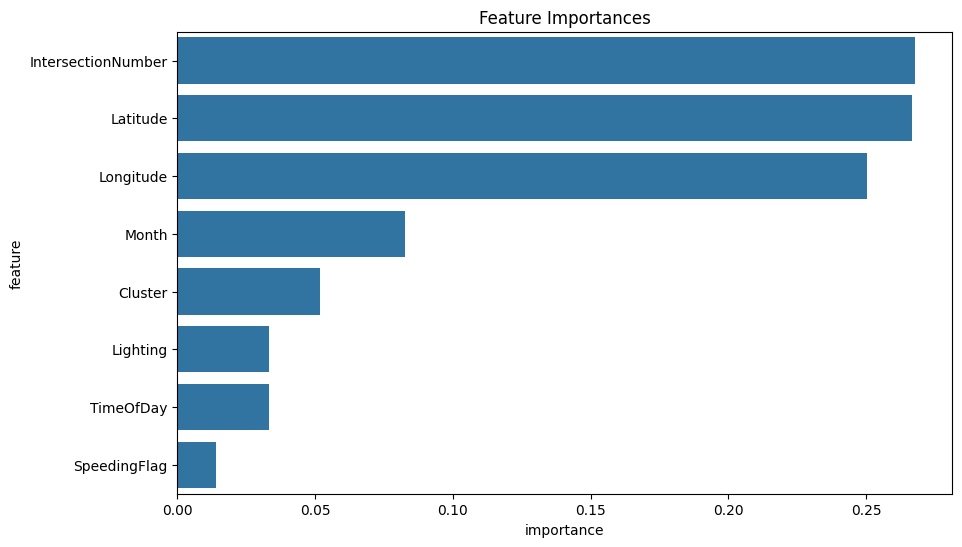

In [ ]:

# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Display feature importances
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

#### Decision Tree

The Decision Tree performed well in comparison to other models with an accuracy score of 93.78 and F1 score of 94.59 . However, given that the tree was heavily complex with a long depth, the tree was much harder to interpret and thus determining whether the tree was generalizable was difficult even after pruning and reducing the depth of the tree to 5. When reducing the depth we found that the accuracy and metrics were significantly compromised.

Decision Tree Model Evaluation:
Accuracy: 0.9378054198134163
Precision: 0.9209932279909706
Recall: 0.9722001588562351
F1-Score: 0.9459041731066461
Confusion Matrix:
 [[ 887  105]
 [  35 1224]]


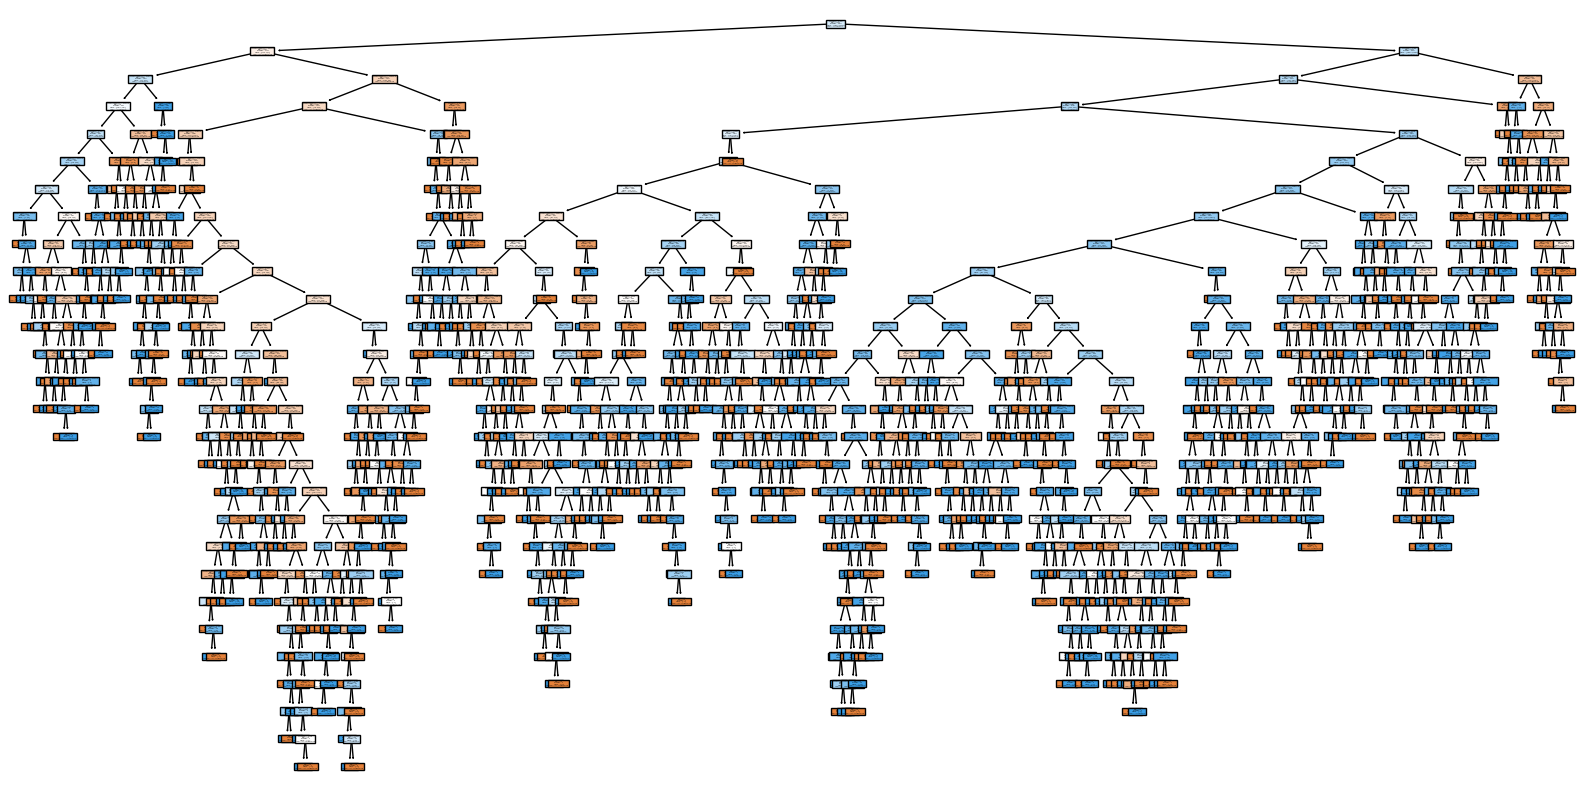

In [ ]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions with Decision Tree
y_pred_dt = dt_model.predict(X_test)

# Calculate metrics for Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print('Decision Tree Model Evaluation:')
print('Accuracy:', accuracy_dt)
print('Precision:', precision_dt)
print('Recall:', recall_dt)
print('F1-Score:', f1_dt)
print('Confusion Matrix:\n', conf_matrix_dt)

# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Not Accident-Prone', 'Accident-Prone'])
plt.show()

In [ ]:
# Run cross validation on the decision tree

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the metrics to evaluate
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation
dt_cv_results = cross_validate(
    dt_model, X, y, cv=cv, scoring=scoring, return_train_score=True
)

# Calculate mean and standard deviation for each metric
for metric in scoring:
    print(f"{metric.capitalize()}: {dt_cv_results[f'test_{metric}'].mean():.3f} ± {dt_cv_results[f'test_{metric}'].std():.3f}")

Accuracy: 0.947 ± 0.003
Precision: 0.930 ± 0.008
Recall: 0.979 ± 0.006
F1: 0.954 ± 0.002


Pruned Decision Tree Model Evaluation:
Accuracy: 0.6574855619724567
Precision: 0.650990099009901
Recall: 0.835583796664019
F1-Score: 0.7318260869565217


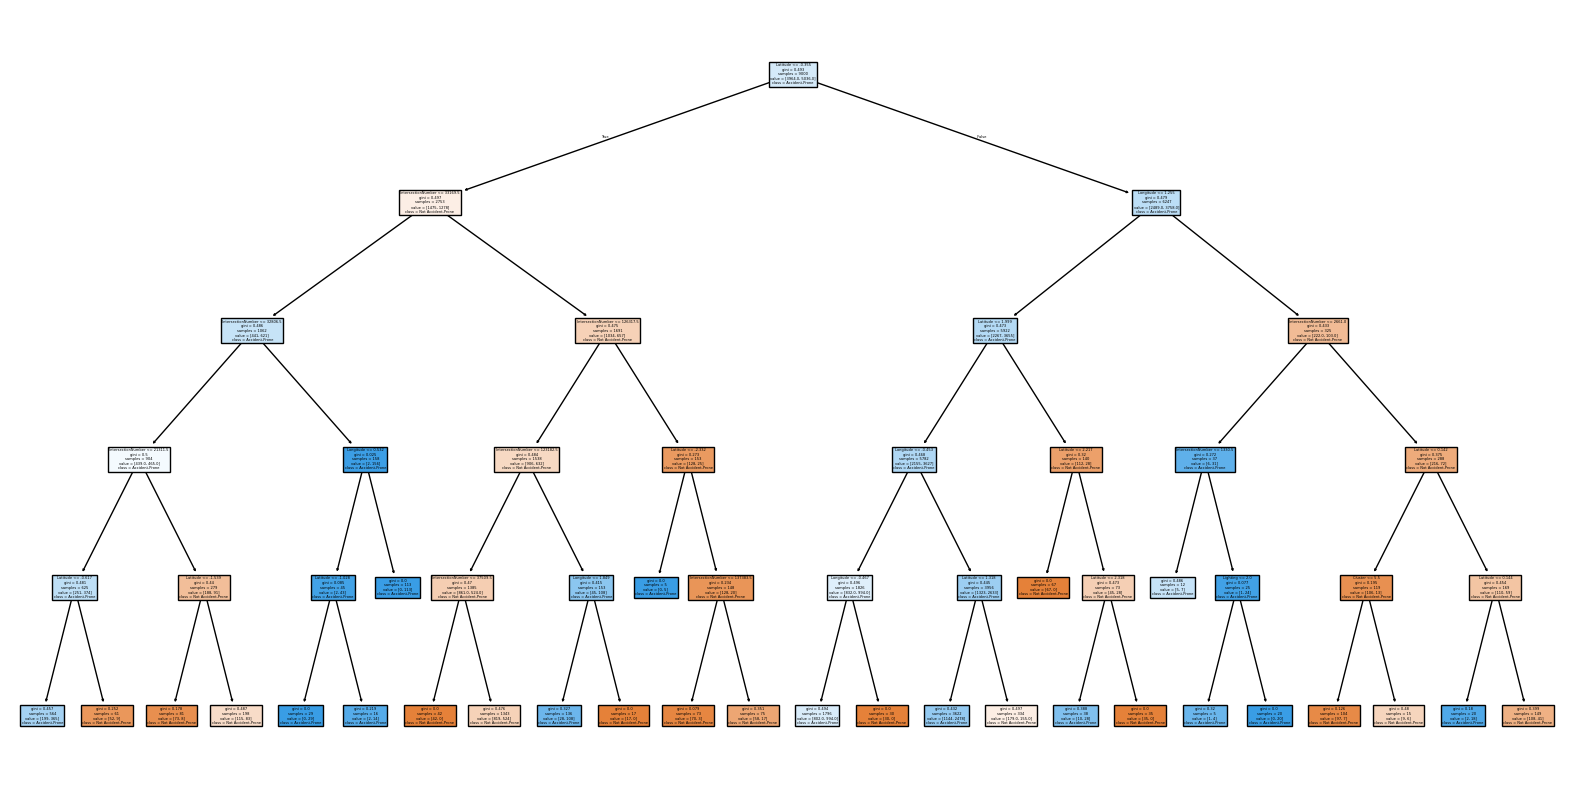

In [ ]:
# Prune the Decision Tree to avoid overfitting
dt_model_pruned = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=20, min_samples_leaf=5)
dt_model_pruned.fit(X_train, y_train)

# Make predictions with the pruned Decision Tree
y_pred_dt_pruned = dt_model_pruned.predict(X_test)

# Calculate metrics for pruned Decision Tree
accuracy_dt_pruned = accuracy_score(y_test, y_pred_dt_pruned)
precision_dt_pruned = precision_score(y_test, y_pred_dt_pruned)
recall_dt_pruned = recall_score(y_test, y_pred_dt_pruned)
f1_dt_pruned = f1_score(y_test, y_pred_dt_pruned)

print('Pruned Decision Tree Model Evaluation:')
print('Accuracy:', accuracy_dt_pruned)
print('Precision:', precision_dt_pruned)
print('Recall:', recall_dt_pruned)
print('F1-Score:', f1_dt_pruned)

# Visualize the pruned Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model_pruned, filled=True, feature_names=X_train.columns, class_names=['Not Accident-Prone', 'Accident-Prone'])
plt.show()


Decision Tree Model Evaluation:
Accuracy: 0.6361617059084851
Precision: 0.6280558789289872
Recall: 0.8570293884034949
F1-Score: 0.7248908296943232
Confusion Matrix:
 [[ 353  639]
 [ 180 1079]]


[Text(0.5, 0.9, 'Latitude <= -0.355\ngini = 0.493\nsamples = 9000\nvalue = [3964.0, 5036.0]\nclass = Accident-Prone'),
 Text(0.25, 0.7, 'IntersectionNumber <= 33169.5\ngini = 0.497\nsamples = 2753\nvalue = [1475, 1278]\nclass = Not Accident-Prone'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'IntersectionNumber <= 32806.5\ngini = 0.486\nsamples = 1062\nvalue = [441, 621]\nclass = Accident-Prone'),
 Text(0.0625, 0.3, 'IntersectionNumber <= 21311.5\ngini = 0.5\nsamples = 904\nvalue = [439.0, 465.0]\nclass = Accident-Prone'),
 Text(0.03125, 0.1, 'gini = 0.481\nsamples = 625\nvalue = [251, 374]\nclass = Accident-Prone'),
 Text(0.09375, 0.1, 'gini = 0.44\nsamples = 279\nvalue = [188, 91]\nclass = Not Accident-Prone'),
 Text(0.1875, 0.3, 'Longitude <= -0.082\ngini = 0.025\nsamples = 158\nvalue = [2, 156]\nclass = Accident-Prone'),
 Text(0.15625, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Not Accident-Prone'),
 Text(0.21875, 0.1, 'gini = 0.013\nsamples = 157\nvalue = [1, 156]\

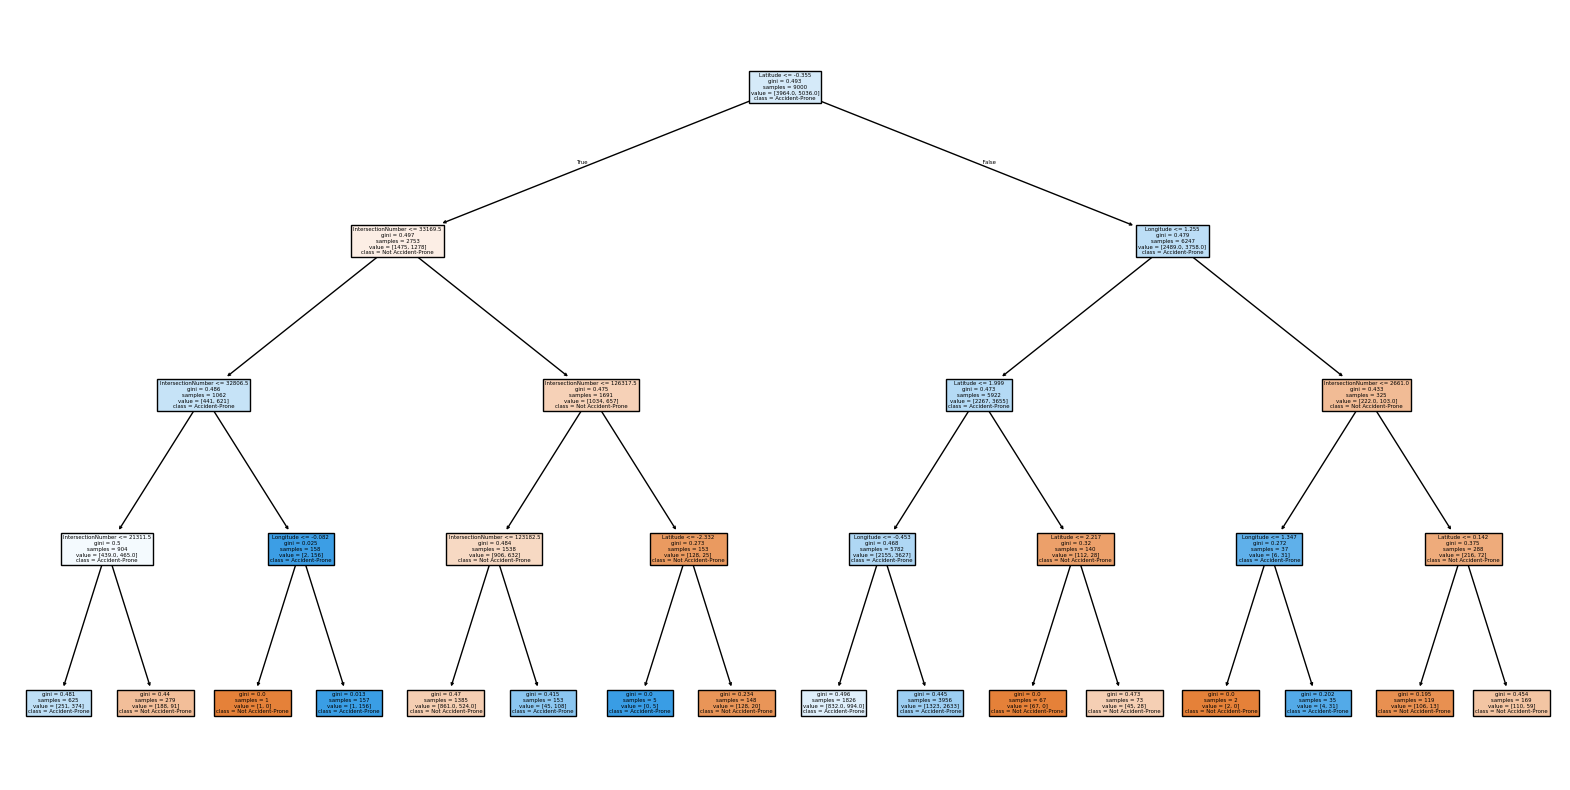

In [ ]:


# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

ccp_alpha_value = 0.01  # Start with a small value to prevent over-pruning
dt_model_pruned = DecisionTreeClassifier(random_state=42, max_depth=4)

# Train Decision Tree Classifier
dt_model_pruned.fit(X_train, y_train)

# Make predictions with Decision Tree
y_pred_dt = dt_model_pruned.predict(X_test)

# Calculate metrics for Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print('Decision Tree Model Evaluation:')
print('Accuracy:', accuracy_dt)
print('Precision:', precision_dt)
print('Recall:', recall_dt)
print('F1-Score:', f1_dt)
print('Confusion Matrix:\n', conf_matrix_dt)

# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model_pruned, filled=True, feature_names=X_train.columns, class_names=['Not Accident-Prone', 'Accident-Prone'])

#### Boosting

##### Gradient Boost

In [ ]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=500,  )
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Evaluation metrics for Gradient Boosting
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

print('Gradient Boosting Model Evaluation:')
print('Accuracy:', accuracy_gb)
print('Precision:', precision_gb)
print('Recall:', recall_gb)
print('F1-Score:', f1_gb)
print('Confusion Matrix:\n', conf_matrix_gb)

Gradient Boosting Model Evaluation:
Accuracy: 0.8489560195468681
Precision: 0.8238195912614518
Recall: 0.9285146942017474
F1-Score: 0.8730395817774459
Confusion Matrix:
 [[ 742  250]
 [  90 1169]]


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create dictionaries to store scores for each metric
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    # Split data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train the Gradient Boosting model
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test set
    y_pred_fold = gb_model.predict(X_test_fold)

    # Calculate and store scores for each metric
    accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
    precision_scores.append(precision_score(y_test_fold, y_pred_fold))
    recall_scores.append(recall_score(y_test_fold, y_pred_fold))
    f1_scores.append(f1_score(y_test_fold, y_pred_fold))

# Calculate and print average scores
print(f"Average CrossAccuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f}")


Average CrossAccuracy: 0.7302
Average Precision: 0.7142
Average Recall: 0.8637
Average F1-Score: 0.7818


##### Feature Importances

In [ ]:
feature_importances = gb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
print(importance_df.sort_values(by='Importance', ascending=False))


              Feature  Importance
4  IntersectionNumber    0.405630
1           Longitude    0.279307
0            Latitude    0.260683
7             Cluster    0.028790
6           TimeOfDay    0.014720
2            Lighting    0.007659
5               Month    0.001653
3        SpeedingFlag    0.001559


In [ ]:
X.head()

,Latitude,Longitude,Lighting,SpeedingFlag,IntersectionNumber,Month,TimeOfDay,Cluster
0,37.300611,-121.936797,3,True,110241,11,0,2
1,37.302711,-121.966043,1,True,22770,3,1,1
2,37.306535,-121.966047,3,False,22857,6,1,1
3,37.305191,-121.966039,3,False,22868,4,0,1
4,37.305191,-121.966039,3,False,22868,2,2,1


##### XGBoost

In [ ]:
# XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation metrics for XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print('XGBoost Model Evaluation:')
print('Accuracy:', accuracy_xgb)
print('Precision:', precision_xgb)
print('Recall:', recall_xgb)
print('F1-Score:', f1_xgb)
print('Confusion Matrix:\n', conf_matrix_xgb)

XGBoost Model Evaluation:
Accuracy: 0.9115948467347845
Precision: 0.8868613138686131
Recall: 0.9650516282764099
F1-Score: 0.9243058197033093
Confusion Matrix:
 [[ 837  155]
 [  44 1215]]


In [ ]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds, shuffled data

# Store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through each fold
for train_index, test_index in skf.split(X, y):
    # Split data for the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train XGBoost model
    xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
    xgb_model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test fold
    y_pred_fold = xgb_model.predict(X_test_fold)

    # Calculate and store evaluation metrics for the fold
    accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
    precision_scores.append(precision_score(y_test_fold, y_pred_fold))
    recall_scores.append(recall_score(y_test_fold, y_pred_fold))
    f1_scores.append(f1_score(y_test_fold, y_pred_fold))

# Print the average evaluation metrics across all folds
print('XGBoost Model Evaluation with Stratified Cross-Validation:')
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f}")

XGBoost Model Evaluation with Stratified Cross-Validation:
Average Accuracy: 0.9145
Average Precision: 0.8970
Average Recall: 0.9571
Average F1-Score: 0.9261


##### CatBoost

In [ ]:
!pip install catboost

from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(random_state=42, verbose=100)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

# Evaluation metrics
accuracy_cat = accuracy_score(y_test, y_pred_cat)
precision_cat = precision_score(y_test, y_pred_cat)
recall_cat = recall_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)

print('CatBoost Model Evaluation:')
print('Accuracy:', accuracy_cat)
print('Precision:', precision_cat)
print('Recall:', recall_cat)
print('F1-Score:', f1_cat)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00
Learning rate set to 0.026327
0:	learn: 0.6908069	total: 52ms	remaining: 51.9s
100:	learn: 0.6000541	total: 439ms	remaining: 3.9s
200:	learn: 0.5641646	total: 813ms	remaining: 3.23s
300:	learn: 0.5303623	total: 1.19s	remaining: 2.77s
400:	learn: 0.4928347	total: 1.57s	remaining: 2.35s
500:	learn: 0.4574250	total: 1.93s	remaining: 1.92s
600:	learn: 0.4262058	total: 2.3s	remaining: 1.53s
700:	learn: 0.3994079	total: 2.69s	remaining: 1.15s
800:	learn: 0.3776821	total: 3.06s	remaining: 759ms
900:	learn: 0.3565946	total: 3.43s	remaining: 377ms
999:	learn: 0.3374734	total: 3.82s	remaining: 0us
CatBoost Model Evaluation:
Accuracy: 0.8494002665482008
Precision: 0.8225806451612904
Recall: 0.931691818903892
F1-Score: 0.8737430167597765


In [ ]:
# run a stratified k fold cross validation on cat boost model

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through each fold
for train_index, test_index in skf.split(X, y):
    # Split data for the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train CatBoost model
    cat_model = CatBoostClassifier(random_state=42, verbose=0) # Set verbose to 0 to suppress output
    cat_model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test fold
    y_pred_fold = cat_model.predict(X_test_fold)

    # Calculate and store evaluation metrics for the fold
    accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
    precision_scores.append(precision_score(y_test_fold, y_pred_fold))
    recall_scores.append(recall_score(y_test_fold, y_pred_fold))
    f1_scores.append(f1_score(y_test_fold, y_pred_fold))

# Print the average evaluation metrics across all folds
print('CatBoost Model Evaluation with Stratified Cross-Validation:')
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f}")

CatBoost Model Evaluation with Stratified Cross-Validation:
Average Accuracy: 0.8569
Average Precision: 0.8364
Average Recall: 0.9255
Average F1-Score: 0.8787


### Other models

#### KNN & SVM

In [ ]:

# Stratified K-Fold Cross-Validation for KNN and SVM
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds, shuffled data
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
# Store evaluation metrics for KNN and SVM
knn_accuracy_scores = []
knn_precision_scores = []
knn_recall_scores = []
knn_f1_scores = []

svm_accuracy_scores = []
svm_precision_scores = []
svm_recall_scores = []
svm_f1_scores = []

# Loop through each fold for KNN and SVM
for train_index, test_index in skf.split(X, y):
    # Split data for the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # KNN Classifier
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_fold, y_train_fold)
    y_pred_knn = knn_model.predict(X_test_fold)

    # Store evaluation metrics for KNN
    knn_accuracy_scores.append(accuracy_score(y_test_fold, y_pred_knn))
    knn_precision_scores.append(precision_score(y_test_fold, y_pred_knn))
    knn_recall_scores.append(recall_score(y_test_fold, y_pred_knn))
    knn_f1_scores.append(f1_score(y_test_fold, y_pred_knn))

    # SVM Classifier
    svm_model = SVC(random_state=42)
    svm_model.fit(X_train_fold, y_train_fold)
    y_pred_svm = svm_model.predict(X_test_fold)

    # Store evaluation metrics for SVM
    svm_accuracy_scores.append(accuracy_score(y_test_fold, y_pred_svm))
    svm_precision_scores.append(precision_score(y_test_fold, y_pred_svm))
    svm_recall_scores.append(recall_score(y_test_fold, y_pred_svm))
    svm_f1_scores.append(f1_score(y_test_fold, y_pred_svm))

# Print the average evaluation metrics across all folds for KNN
print('KNN Model Evaluation with Stratified Cross-Validation:')
print(f"Average Accuracy: {np.mean(knn_accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(knn_precision_scores):.4f}")
print(f"Average Recall: {np.mean(knn_recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(knn_f1_scores):.4f}")

# Print the average evaluation metrics across all folds for SVM
print('SVM Model Evaluation with Stratified Cross-Validation:')
print(f"Average Accuracy: {np.mean(svm_accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(svm_precision_scores):.4f}")
print(f"Average Recall: {np.mean(svm_recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(svm_f1_scores):.4f}")

KNN Model Evaluation with Stratified Cross-Validation:
Average Accuracy: 0.8631
Average Precision: 0.8226
Average Recall: 0.9631
Average F1-Score: 0.8873
SVM Model Evaluation with Stratified Cross-Validation:
Average Accuracy: 0.5735
Average Precision: 0.5692
Average Recall: 0.9768
Average F1-Score: 0.7193


#### LGBM Classifer

In [ ]:
from lightgbm import LGBMClassifier
!pip install dask[dataframe]
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# Evaluation metrics
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)

print('LightGBM Model Evaluation:')
print('Accuracy:', accuracy_lgb)
print('Precision:', precision_lgb)
print('Recall:', recall_lgb)
print('F1-Score:', f1_lgb)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.5 MB/s eta 0:00:00
[LightGBM] [Info] Number of positive: 5036, number of negative: 3964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559556 -> initscore=0.239358
[LightGBM] [Info] Start training from score 0.239358
LightGBM Model Evaluation:
Accuracy: 0.8378498445135495
Precision: 0.8130252100840336
Recall: 0.9221604447974583
F1-Score: 0.8641607740975065


In [ ]:
# prompt: Run cross vlaidation strastified k-fold for lgihtGBM

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize LightGBM model
lgb_model = LGBMClassifier(random_state=42)

# Perform cross-validation
scoring = 'accuracy' # Example metric, change as needed
cv_scores = cross_val_score(lgb_model, X, y, cv=skf, scoring=scoring)

# Print results
print(f"LightGBM Cross-Validation ({scoring}) Scores: {cv_scores}")
print(f"Mean {scoring}: {cv_scores.mean():.4f}")
print(f"Standard Deviation {scoring}: {cv_scores.std():.4f}")

# Other scoring metrics examples:
# scoring = 'precision'
# scoring = 'recall'
# scoring = 'f1'
# scoring = 'roc_auc' # For binary classification

[LightGBM] [Info] Number of positive: 5036, number of negative: 3964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559556 -> initscore=0.239358
[LightGBM] [Info] Start training from score 0.239358


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 5036, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 9001, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559493 -> initscore=0.239106
[LightGBM] [Info] Start training from score 0.239106


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 5036, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 9001, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559493 -> initscore=0.239106
[LightGBM] [Info] Start training from score 0.239106


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 5036, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 9001, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559493 -> initscore=0.239106
[LightGBM] [Info] Start training from score 0.239106


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 5036, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 9001, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559493 -> initscore=0.239106
[LightGBM] [Info] Start training from score 0.239106
LightGBM Cross-Validation (accuracy) Scores: [0.84584629 0.86222222 0.84222222 0.85777778 0.84977778]
Mean accuracy: 0.8516
Standard Deviation accuracy: 0.0074


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty='l2', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Evaluation metrics
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

print('Logistic Regression Model Evaluation:')
print('Accuracy:', accuracy_log)
print('Precision:', precision_log)
print('Recall:', recall_log)
print('F1-Score:', f1_log)


Logistic Regression Model Evaluation:
Accuracy: 0.5855175477565526
Precision: 0.5933562428407789
Recall: 0.8228752978554408
F1-Score: 0.6895174708818635


#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Evaluation metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print('Naive Bayes Model Evaluation:')
print('Accuracy:', accuracy_nb)
print('Precision:', precision_nb)
print('Recall:', recall_nb)
print('F1-Score:', f1_nb)


Naive Bayes Model Evaluation:
Accuracy: 0.5748556197245669
Precision: 0.5728764478764479
Recall: 0.9428117553613979
F1-Score: 0.7126988892224557


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

# Evaluation metrics
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print('Neural Network Model (MLP) Evaluation:')
print('Accuracy:', accuracy_mlp)
print('Precision:', precision_mlp)
print('Recall:', recall_mlp)
print('F1-Score:', f1_mlp)


Neural Network Model (MLP) Evaluation:
Accuracy: 0.4420257663260773
Precision: 0.6666666666666666
Recall: 0.004765687053216839
F1-Score: 0.00946372239747634
